In [1]:
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')

import io
from google.colab import drive
drive.mount('/content/gdrive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 19 18:31:19 2019

@author: lenovo2019
"""

#split sentences
#remove stop words on sentence
#stemming on word
#make lower each word


from nltk.tokenize import sent_tokenize #, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm,trange #visualize processing

sentTokenizer = nltk.sent_tokenize
wordTokenizer = RegexpTokenizer(r'\w+')
stopWords = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

textPath = "/content/gdrive/My Drive/files/metamorphosis.txt"

def readBook(path):
    f = open(path, "r")
    book = f.read()
    return book
    

def preprocess_text(document):
    #sentences
    print("\n ##sentences&wordSet process## \n")
    wordSet = set()
    whole_sentences = sentTokenizer(document)
    parsed_sentences = [wordTokenizer.tokenize(sent) for sent in tqdm(whole_sentences)]
    
    for iSent in trange(len(parsed_sentences)):
        for word in parsed_sentences[iSent]:
            indexWord = parsed_sentences[iSent].index(word)
            if word in stopWords or word.isalpha() == False:
                parsed_sentences[iSent].remove(word)             
            elif word.isalpha():
                #parsed_sentences[iSent][indexWord] = word.lower()
                parsed_sentences[iSent][indexWord] = stemmer.stem(parsed_sentences[iSent][indexWord])
                wordSet.add(parsed_sentences[iSent][indexWord])
                
    print("\n ##word2int enumeration process## \n")
    word2int = {}
    
    for i,word in tqdm(enumerate(wordSet)):
        word2int[word] = i
        
    parsed_sentences[0].remove(parsed_sentences[0][0])
    
    print("\n ##windowsize words process## \n")
    
    WINDOW_SIZE = 2
    neighbor_data = []
    for sentence in tqdm(parsed_sentences, total=len(parsed_sentences)):
        for idx, word in enumerate(sentence):
            for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
                if neighbor != word:
                    if(word in wordSet and neighbor in wordSet):
                        neighbor_data.append([word, neighbor])

    return parsed_sentences, wordSet, word2int, neighbor_data

book = readBook(textPath)

SentenceList, wordSet, word2int, neighbor_data = preprocess_text(book)



df = pd.DataFrame(neighbor_data, columns = ['input', 'label'])

100%|██████████| 798/798 [00:00<00:00, 6491.96it/s]
1527it [00:00, 732300.73it/s]
  0%|          | 0/798 [00:00<?, ?it/s]


 ##sentences&wordSet process## 


 ##word2int enumeration process## 


 ##windowsize words process## 



100%|██████████| 798/798 [00:00<00:00, 4749.02it/s]


In [3]:
##### TRAINING DATA #########

ONE_HOT_DIM = len(wordSet)

# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word

print("\n ##ZIPPING PROCESS## \n")

for x, y in tqdm(zip(df['input'], df['label'])):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))


# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# making placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2 

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

4179it [00:00, 41787.45it/s]


 ##ZIPPING PROCESS## 



34654it [00:00, 41457.42it/s]


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [10]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 5000
for i in tqdm(range(iteration)):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 100 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

# Now the hidden layer (W1 + b1) is actually the word look up table
vectors = sess.run(W1 + b1)

w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = wordSet
w2v_df = w2v_df[['word', 'x1', 'x2']]

  0%|          | 1/5000 [00:01<2:18:43,  1.66s/it]

iteration 0 loss is :  9.702422


  2%|▏         | 101/5000 [02:15<2:04:58,  1.53s/it]

iteration 100 loss is :  8.210297


  4%|▍         | 201/5000 [04:29<2:02:10,  1.53s/it]

iteration 200 loss is :  8.122645


  6%|▌         | 301/5000 [06:42<1:59:41,  1.53s/it]

iteration 300 loss is :  8.056948


  8%|▊         | 401/5000 [08:56<1:56:47,  1.52s/it]

iteration 400 loss is :  8.003275


 10%|█         | 501/5000 [11:09<1:54:41,  1.53s/it]

iteration 500 loss is :  7.957032


 12%|█▏        | 601/5000 [13:23<1:51:47,  1.52s/it]

iteration 600 loss is :  7.915744


 14%|█▍        | 701/5000 [15:37<1:49:47,  1.53s/it]

iteration 700 loss is :  7.877874


 16%|█▌        | 801/5000 [17:51<1:47:18,  1.53s/it]

iteration 800 loss is :  7.8423657


 18%|█▊        | 901/5000 [20:05<1:44:36,  1.53s/it]

iteration 900 loss is :  7.8084493


 20%|██        | 1001/5000 [22:19<1:43:15,  1.55s/it]

iteration 1000 loss is :  7.775587


 22%|██▏       | 1101/5000 [24:33<1:39:35,  1.53s/it]

iteration 1100 loss is :  7.74348


 24%|██▍       | 1201/5000 [26:46<1:36:25,  1.52s/it]

iteration 1200 loss is :  7.7121263


 26%|██▌       | 1301/5000 [28:59<1:34:12,  1.53s/it]

iteration 1300 loss is :  7.681754


 28%|██▊       | 1401/5000 [31:13<1:31:50,  1.53s/it]

iteration 1400 loss is :  7.6525755


 30%|███       | 1501/5000 [33:26<1:29:13,  1.53s/it]

iteration 1500 loss is :  7.6245255


 32%|███▏      | 1601/5000 [35:40<1:26:36,  1.53s/it]

iteration 1600 loss is :  7.5972886


 34%|███▍      | 1701/5000 [37:53<1:24:05,  1.53s/it]

iteration 1700 loss is :  7.570497


 36%|███▌      | 1801/5000 [40:07<1:21:58,  1.54s/it]

iteration 1800 loss is :  7.543864


 38%|███▊      | 1901/5000 [42:21<1:18:50,  1.53s/it]

iteration 1900 loss is :  7.517189


 40%|████      | 2001/5000 [44:34<1:16:16,  1.53s/it]

iteration 2000 loss is :  7.4903364


 42%|████▏     | 2101/5000 [46:48<1:13:49,  1.53s/it]

iteration 2100 loss is :  7.4632063


 44%|████▍     | 2201/5000 [49:02<1:10:41,  1.52s/it]

iteration 2200 loss is :  7.435722


 46%|████▌     | 2301/5000 [51:16<1:09:10,  1.54s/it]

iteration 2300 loss is :  7.4078264


 48%|████▊     | 2401/5000 [53:29<1:06:33,  1.54s/it]

iteration 2400 loss is :  7.379478


 50%|█████     | 2501/5000 [55:43<1:03:45,  1.53s/it]

iteration 2500 loss is :  7.3506575


 52%|█████▏    | 2601/5000 [57:56<1:01:48,  1.55s/it]

iteration 2600 loss is :  7.321368


 54%|█████▍    | 2701/5000 [1:00:10<58:42,  1.53s/it]

iteration 2700 loss is :  7.2916403


 56%|█████▌    | 2801/5000 [1:02:24<56:12,  1.53s/it]

iteration 2800 loss is :  7.2615414


 58%|█████▊    | 2901/5000 [1:04:37<53:54,  1.54s/it]

iteration 2900 loss is :  7.2311883


 60%|██████    | 3001/5000 [1:06:51<50:49,  1.53s/it]

iteration 3000 loss is :  7.200769


 62%|██████▏   | 3101/5000 [1:09:05<48:24,  1.53s/it]

iteration 3100 loss is :  7.170568


 64%|██████▍   | 3201/5000 [1:11:19<45:49,  1.53s/it]

iteration 3200 loss is :  7.1409893


 66%|██████▌   | 3301/5000 [1:13:33<43:21,  1.53s/it]

iteration 3300 loss is :  7.1125364


 68%|██████▊   | 3401/5000 [1:15:46<40:39,  1.53s/it]

iteration 3400 loss is :  7.085682


 70%|███████   | 3501/5000 [1:18:00<38:18,  1.53s/it]

iteration 3500 loss is :  7.060653


 72%|███████▏  | 3601/5000 [1:20:14<35:39,  1.53s/it]

iteration 3600 loss is :  7.03731


 74%|███████▍  | 3701/5000 [1:22:28<33:15,  1.54s/it]

iteration 3700 loss is :  7.015295


 76%|███████▌  | 3801/5000 [1:24:42<30:28,  1.53s/it]

iteration 3800 loss is :  6.9942794


 78%|███████▊  | 3901/5000 [1:26:56<28:03,  1.53s/it]

iteration 3900 loss is :  6.9740615


 80%|████████  | 4001/5000 [1:29:09<25:20,  1.52s/it]

iteration 4000 loss is :  6.954539


 82%|████████▏ | 4101/5000 [1:31:24<23:08,  1.54s/it]

iteration 4100 loss is :  6.9356523


 84%|████████▍ | 4201/5000 [1:33:38<20:46,  1.56s/it]

iteration 4200 loss is :  6.9173656


 86%|████████▌ | 4301/5000 [1:35:52<17:53,  1.54s/it]

iteration 4300 loss is :  6.8996515


 88%|████████▊ | 4401/5000 [1:38:07<15:21,  1.54s/it]

iteration 4400 loss is :  6.8824797


 90%|█████████ | 4501/5000 [1:40:22<12:49,  1.54s/it]

iteration 4500 loss is :  6.865826


 92%|█████████▏| 4601/5000 [1:42:36<10:10,  1.53s/it]

iteration 4600 loss is :  6.8496666


 94%|█████████▍| 4701/5000 [1:44:51<07:46,  1.56s/it]

iteration 4700 loss is :  6.833976


 96%|█████████▌| 4801/5000 [1:47:06<05:09,  1.55s/it]

iteration 4800 loss is :  6.8187346


 98%|█████████▊| 4901/5000 [1:49:20<02:31,  1.53s/it]

iteration 4900 loss is :  6.803926


100%|██████████| 5000/5000 [1:51:32<00:00,  1.33s/it]


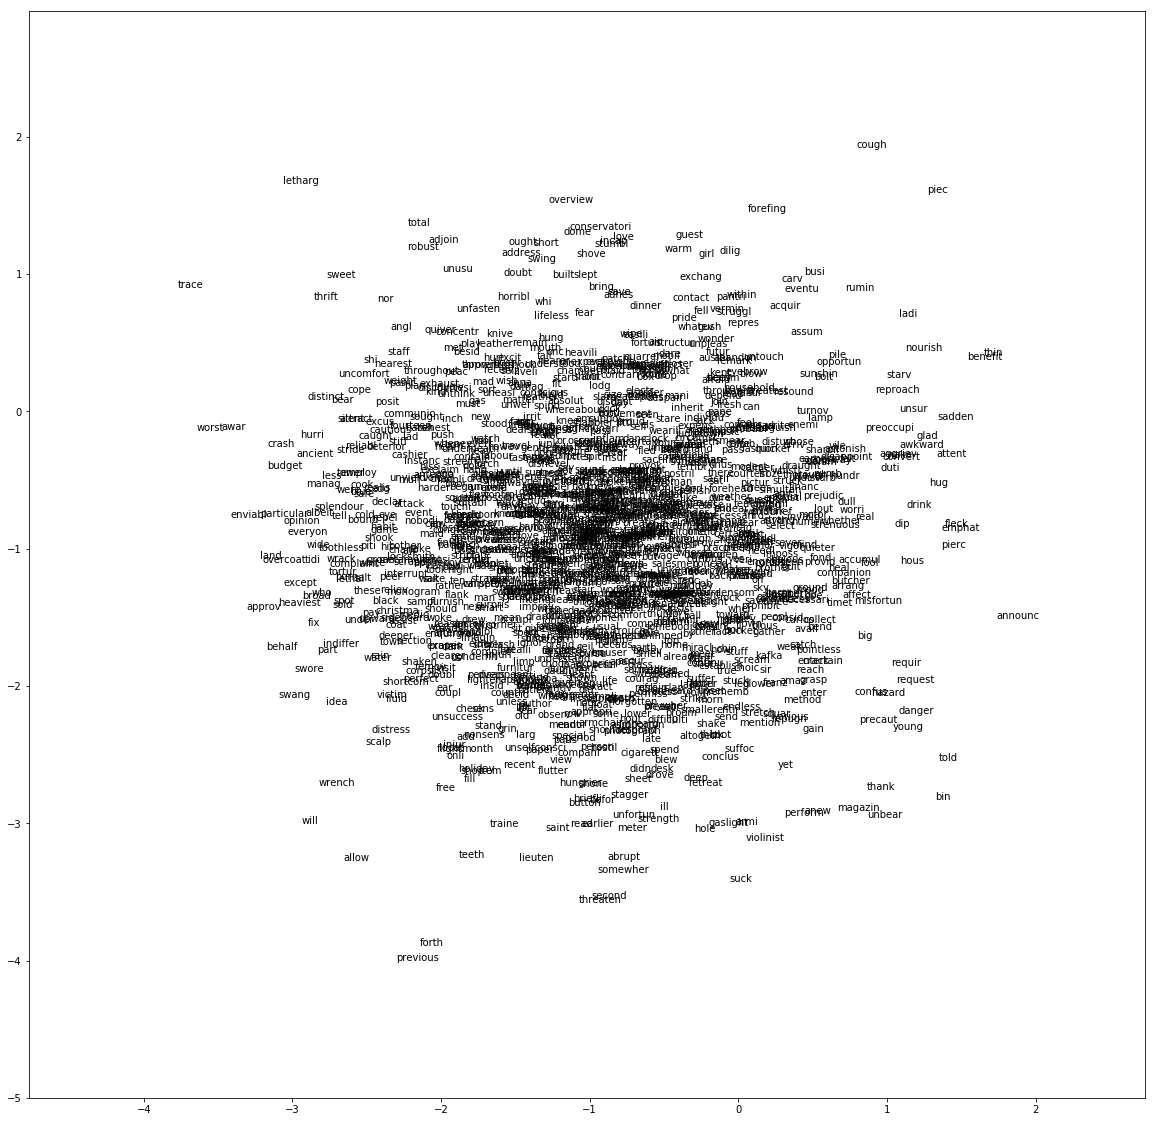

In [36]:
##Visualization##
fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()

In [26]:
#take a loop first 10 rows
w2v_df.head(10)

,word,x1,x2
0,fill,-1.850500,-2.695640
1,secret,-0.952833,-0.321723
2,glanc,-1.769995,-1.129725
3,their,-0.530241,-0.902594
4,said,-0.862357,-1.255442
5,agre,-0.070321,-1.177202
6,pleasur,-0.641249,-2.172991
7,entranc,-1.229039,-1.190682
8,froze,0.136946,-0.478026
9,stuck,-0.104912,-1.986895


In [25]:
#get output to save and use later
w2v_df.to_csv(index=True)

',word,x1,x2\n0,fill,-1.8504999,-2.6956396\n1,secret,-0.9528335,-0.3217225\n2,glanc,-1.769995,-1.1297253\n3,their,-0.5302406,-0.9025936\n4,said,-0.86235726,-1.2554421\n5,agre,-0.07032144,-1.1772025\n6,pleasur,-0.6412488,-2.1729908\n7,entranc,-1.2290391,-1.1906823\n8,froze,0.1369462,-0.47802645\n9,stuck,-0.1049121,-1.9868948\n10,case,-0.24993044,-0.7029385\n11,tower,-2.7018604,-0.47087663\n12,burn,-2.7119637,-1.2256064\n13,lethal,-2.7042618,-1.2438474\n14,importun,-0.80417985,-2.3052864\n15,turnov,0.3920654,-0.015313327\n16,knock,-1.6515611,-0.7673896\n17,unthink,-2.0262089,0.108593464\n18,tug,-1.2692295,-1.8947152\n19,sir,0.13981628,-1.906492\n20,tast,-1.5421383,-0.356952\n21,denud,-1.3764889,-2.010911\n22,save,0.04213512,-1.3998162\n23,outsid,-1.7874924,-0.47840142\n24,admit,-1.9339099,-0.6564397\n25,snap,-1.0164193,-0.83286345\n26,sold,-2.729401,-1.4276131\n27,rage,-1.3068956,-2.0798569\n28,incap,-0.9292983,1.2198126\n29,old,-1.5071647,-2.23596\n30,sideboard,-2.4106188,-1.5261014\n31